In [1]:
import re
import json
import time
import pymongo
import multiprocessing
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from textblob import TextBlob
from config import *

## Helper Function

In [2]:
class TwitterAuth():
    """
    Get authentication for Twitter.
    Get KEY and ACCESS TOKEN from https://developer.twitter.com/en/apps
    from config import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET
    """
    def auth_twitter_app(self):
        auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

class MaxListener(tweepy.StreamListener):
    """
    This simple stream listener prints status text.
    I save returned tweets into a json file.
    If want to change the format or do other data preprocessing, just revise on process_data().
    """
    def __init__(self, tweets_filename, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        self.tweets_filename = tweets_filename
        
    def on_connect(self):
        print("You are now connected to the streaming API.")
    
    def on_data(self, data):
        if (time.time() - self.start_time) < self.limit:
            self.process_data(data)
            return True
        else:
            return False
    
    def process_data(self, data):
        try:
            # print(data)
            with open(self.tweets_filename, 'a') as f:
                f.write(data)
            
            # Store raw_data into mongodb
            client = pymongo.MongoClient(MONGO_CLIENT)
            db = client.twitterdb
            datajson = json.loads(data)
            # Insert the data into the mongodb into a collection called twitter_search
            # If twitter_search doesn't exist, it will be created.
            db.twitter_search.insert_one(datajson)
            return True
        
        except BaseException as e:
            print("Error on data: {}".format(e))
            
        return True 
        
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
class TwitterClient():
    """
    Get my own tweets or others.
    
    Parameters:
        twitter_user: if twitter_user is set to None, it means capture my tweets. Instead, crawl twitter_user tweets. 
    """
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuth().auth_twitter_app()
        self.twitter_client = tweepy.API(self.auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in tweepy.Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in tweepy.Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in tweepy.Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

## Main Function

In [3]:
class MaxStreamer():
    """
    In Tweepy, an instance of tweepy.Stream establishes a streaming session and routes messages to StreamListener instance.
    This MaxStreamer() class could parse tweets in a time interval.
    Next, it would save the tweets into a json file.
    
    Parameters:
        tweets_filename: json file name.
        time_limit: In default, MaxStreamer will close in 60 sec.
    Return:
        MaxStreamer() class will return a json format file in the current working directory.
    Usage:
        maxstreamer = MaxStreamer(tweets_filename="tweets.json", time_limit=60)
        maxstreamer.start(keyword_list=["sheffield"])
    """
    def __init__(self, tweets_filename, time_limit=60):
        self.limit = time_limit
        self.auth = TwitterAuth().auth_twitter_app()
        self.listener = MaxListener(tweets_filename=tweets_filename, time_limit=self.limit)
        self.stream = tweepy.Stream(auth=self.auth, listener=self.listener)
        
    def start(self, keyword_list):
        self.stream.filter(track=keyword_list)
        
class TwitterSearch():
    """
    Twitter Search API.
    This TwitterSearch() class could parse query in a constrained amount.
    
    Usage:
        twitter_searcher = TwitterSearch()
        searched_tweets = twitter_searcher.get_query(query="sheffield", max_tweets=100)
    """
    def __init__(self):
        self.api = TwitterClient().get_twitter_client_api()
    
    def get_query(self, query, max_tweets=100):
        searched_tweets = []
        self.last_id = -1
        self.max_tweets = max_tweets
        self.query = query
        while len(searched_tweets) < self.max_tweets:
            count = self.max_tweets - len(searched_tweets)
            try:
                new_tweets = api.search(q=self.query, count=count, max_id=str(self.last_id-1), 
                                        result_type="recent", tweet_mode="extended")
                if not new_tweets:
                    break
                searched_tweets.extend(new_tweets)
                self.last_id = new_tweets[-1].id
                
            except tweepy.TweepError as e:
                print(e)
                break
        client = pymongo.MongoClient(MONGO_CLIENT)
        db = client.twitterdb
        for i in tqdm(range(max_tweets)):
            # Insert the data into the mongodb into a collection called twitter_search
            # If twitter_search doesn't exist, it will be created.
            db.twitter_search.insert_one(searched_tweets[i]._json)
        return searched_tweets
    
class TweetAnalyzer():
    """
    An analyzer to tweets.
    
    Usage: 
        api = TwitterClient().get_twitter_client_api()
        tweets = api.user_timeline(screen_name="sheffield", count=100)
        df = tweet_analyzer.tweets_to_dataframe(tweets)
    """
    def clean_tweet(self, text):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    
    def get_polarity(self, text):
        try:
            textblob = TextBlob(unicode(self.clean_tweet(text), 'utf-8'))
            polarity = textblob.sentiment.polarity
        except:
            polarity = 0.0
        return polarity
    
    def get_subjectivity(self, text):
        try:
            textblob = TextBlob(unicode(self.clean_tweet(text), 'utf-8'))
            subjectivity = textblob.sentiment.subjectivity
        except:
            subjectivity = 0.0
        return subjectivity
    
    def tweets_to_dataframe(self, tweets):
        df = pd.DataFrame()
        df["tweet"] = np.array([tweet.text for tweet in tweets])
        df["polarity"] = df['tweet'].apply(self.get_polarity)
        df["subjectivity"] = df['tweet'].apply(self.get_subjectivity)
        df['word_count'] = np.array([len(tweet.text) for tweet in tweets])
        df['char_count'] = df['tweet'].apply(lambda x : len(x.replace(" ","")))
        df['word_density'] = df['word_count'] / (df['char_count'] + 1)
        df["id"] = np.array([tweet.id for tweet in tweets])
        df["geography"] = np.array([tweet.geo for tweet in tweets])
        df["favorite_count"] = np.array([tweet.favorite_count for tweet in tweets])
        df["retweet_count"] = np.array([tweet.retweet_count for tweet in tweets])
        df["date"] = np.array([tweet.created_at for tweet in tweets])
        df["source"] = np.array([tweet.source for tweet in tweets])
        return df

## Examples

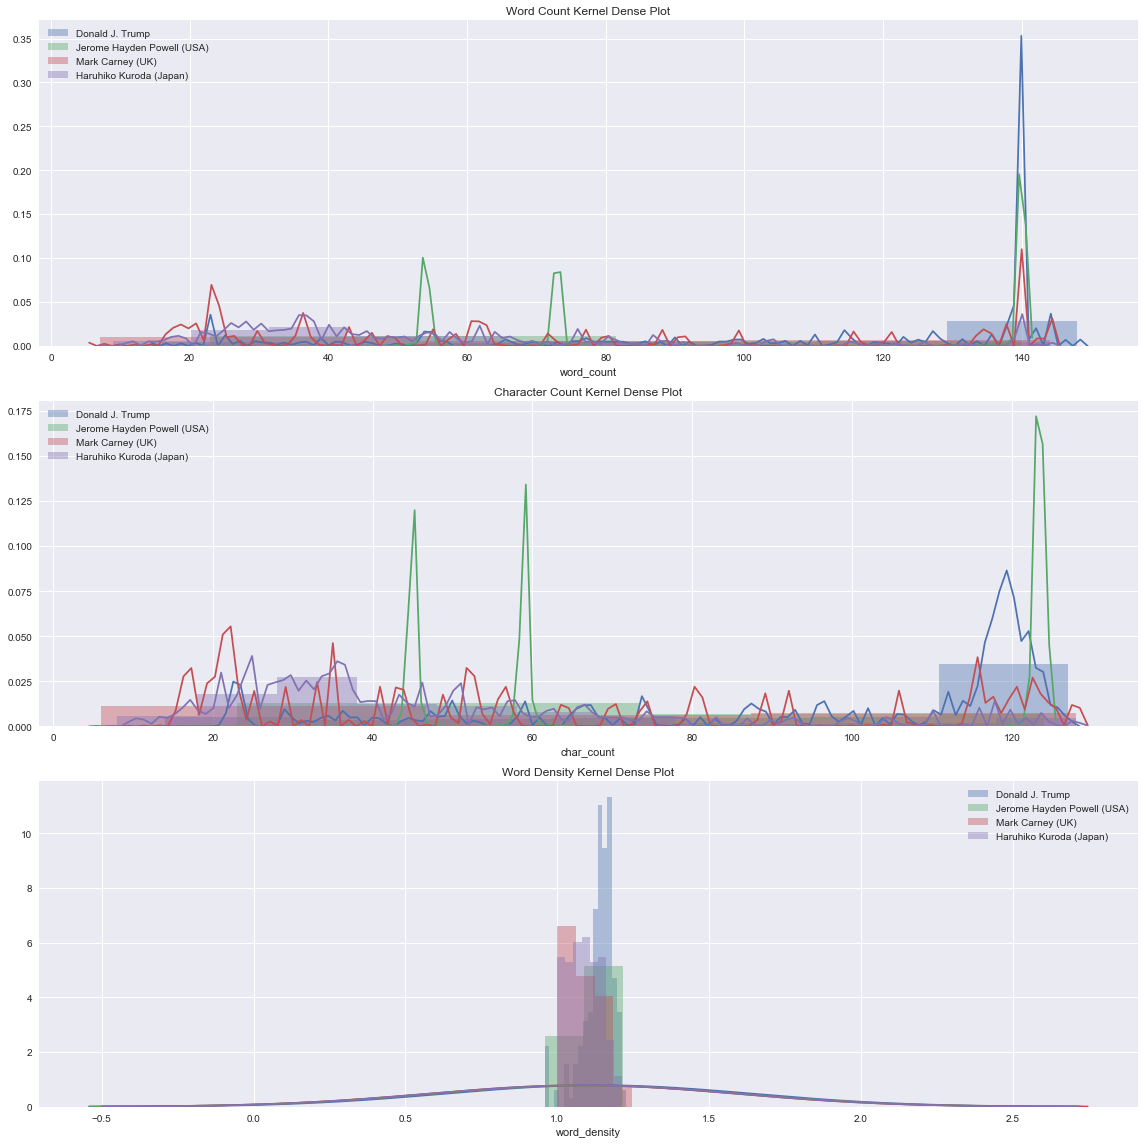

In [4]:
"""
Donald J. Trump: realDonaldTrump
Jerome Hayden Powell (USA): JeromeHaydenPo2
Mark Carney (UK): carneyms
Haruhiko Kuroda (Japan): IvanWKljunak
"""
# Analyse tweet
tweet_analyzer = TweetAnalyzer()
api = TwitterClient().get_twitter_client_api()
tweets_DT = api.user_timeline(screen_name="realDonaldTrump", count=1000)
df_DT = tweet_analyzer.tweets_to_dataframe(tweets_DT)
tweets_US = api.user_timeline(screen_name="JeromeHaydenPo2", count=1000)
df_US = tweet_analyzer.tweets_to_dataframe(tweets_US)
tweets_UK = api.user_timeline(screen_name="carneyms", count=1000)
df_UK = tweet_analyzer.tweets_to_dataframe(tweets_UK)
tweets_JN = api.user_timeline(screen_name="IvanWKljunak", count=1000)
df_JN = tweet_analyzer.tweets_to_dataframe(tweets_JN)

# Some visualization
plt.style.use("seaborn")
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
sns.distplot(df_DT["word_count"], label="Donald J. Trump", kde_kws={'bw': 0.5})
sns.distplot(df_US["word_count"], label="Jerome Hayden Powell (USA)", kde_kws={'bw': 0.5})
sns.distplot(df_UK["word_count"], label="Mark Carney (UK)", kde_kws={'bw': 0.5})
sns.distplot(df_JN["word_count"], label="Haruhiko Kuroda (Japan)", kde_kws={'bw': 0.5})
plt.title("Word Count Kernel Dense Plot")
plt.legend()

plt.subplot(3, 1, 2)
sns.distplot(df_DT["char_count"], label="Donald J. Trump", kde_kws={'bw': 0.5})
sns.distplot(df_US["char_count"], label="Jerome Hayden Powell (USA)", kde_kws={'bw': 0.5})
sns.distplot(df_UK["char_count"], label="Mark Carney (UK)", kde_kws={'bw': 0.5})
sns.distplot(df_JN["char_count"], label="Haruhiko Kuroda (Japan)", kde_kws={'bw': 0.5})
plt.title("Character Count Kernel Dense Plot")
plt.legend()

plt.subplot(3, 1, 3)
sns.distplot(df_DT["word_density"], label="Donald J. Trump", kde_kws={'bw': 0.5})
sns.distplot(df_US["word_density"], label="Jerome Hayden Powell (USA)", kde_kws={'bw': 0.5})
sns.distplot(df_UK["word_density"], label="Mark Carney (UK)", kde_kws={'bw': 0.5})
sns.distplot(df_JN["word_density"], label="Haruhiko Kuroda (Japan)", kde_kws={'bw': 0.5})
plt.title("Word Density Kernel Dense Plot")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
df_DT.head()

,tweet,polarity,subjectivity,word_count,char_count,word_density,id,geography,favorite_count,retweet_count,date,source
0,https://t.co/gjBMFDbUps,0.0,0.0,23,23,0.958333,1272172806579662851,None,66399,16469,2020-06-14 14:23:27,Twitter for iPhone
1,RT @DeptofDefense: First to fight! Happy birth...,0.0,0.0,140,117,1.186441,1272172568670330883,None,0,7236,2020-06-14 14:22:30,Twitter for iPhone
2,"RT @USArmy: Today, we recognize 245 years of b...",0.0,0.0,140,120,1.157025,1272172511560634368,None,0,10427,2020-06-14 14:22:17,Twitter for iPhone
3,RT @ErrolWebber: America is better for having ...,0.0,0.0,123,112,1.088496,1272156371224539136,None,0,14906,2020-06-14 13:18:09,Twitter for iPhone
4,RT @mikandynothem: Happy Birthday Mr. Presiden...,0.0,0.0,140,120,1.157025,1272155800090349569,None,0,13660,2020-06-14 13:15:52,Twitter for iPhone


In [6]:
print("Size of Donald J. Trump dataframe: {}".format(df_DT.shape))
print("Size of Jerome Hayden Powell dataframe: {}".format(df_US.shape))
print("Size of Mark Carney dataframe: {}".format(df_UK.shape))
print("Size of Haruhiko Kuroda dataframe: {}".format(df_JN.shape))

Size of Donald J. Trump dataframe: (200, 12)
Size of Jerome Hayden Powell dataframe: (6, 12)
Size of Mark Carney dataframe: (44, 12)
Size of Haruhiko Kuroda dataframe: (198, 12)


In [7]:
streamer = MaxStreamer(tweets_filename="tweets.json", time_limit=30)
streamer.start(["Trump", "JeromeHaydenPo2", "carneyms", "IvanWKljunak"])

You are now connected to the streaming API.


In [8]:
twitter_search = TwitterSearch()
searched_tweets = twitter_search.get_query(query="forex", max_tweets=1000)

In [9]:
searched_tweets[0]._json

{'created_at': 'Sun Jun 14 19:31:51 +0000 2020',
 'id': 1272250416533831683,
 'id_str': '1272250416533831683',
 'full_text': 'Rea Tsotella has fake forex traders on their show\nnot surprised though',
 'truncated': False,
 'display_text_range': [0, 70],
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1195744562276376577,
  'id_str': '1195744562276376577',
  'name': 'belaire...',
  'screen_name': 'khotsom0lefe',
  'location': ' ',
  'description': '',
  'url': None,
  'entities': {'description': {'urls': []}},
  'protected': False,
  'followers_count': 2908,
  'friends_count': 1450,
  'listed_count': 1,
  'created_a

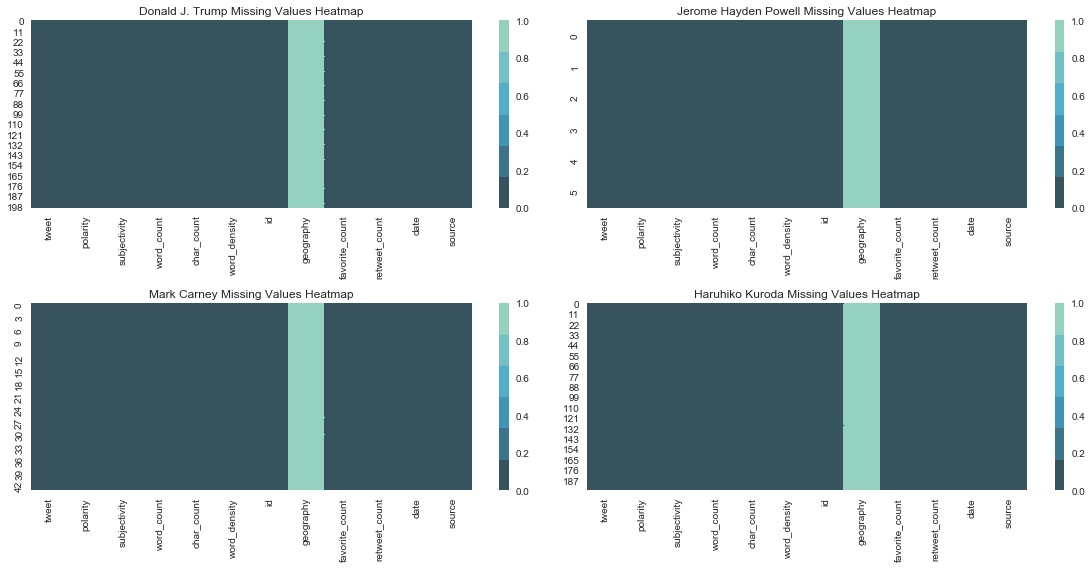

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
sns.heatmap(df_DT.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Donald J. Trump Missing Values Heatmap")
plt.subplot(2, 2, 2)
sns.heatmap(df_US.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Jerome Hayden Powell Missing Values Heatmap")
plt.subplot(2, 2, 3)
sns.heatmap(df_UK.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Mark Carney Missing Values Heatmap")
plt.subplot(2, 2, 4)
sns.heatmap(df_JN.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Haruhiko Kuroda Missing Values Heatmap")

plt.tight_layout()
plt.show()